<a href="https://colab.research.google.com/github/vksriharsha/Human-Cancer-Prediction/blob/main/TCGA_HumanCancer_prediction_CNN_NoTissue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from pycm import *
from matplotlib.pyplot import figure
import seaborn as sn

In [4]:
tcga_data_df = pd.read_csv('/content/drive/MyDrive/Thesis/Human-Cancer-Prediction/TCGA_GTEX_Data_18212_7142.tsv', delimiter='\t')

tcga_metadata_df = pd.read_csv('/content/drive/MyDrive/Thesis/Human-Cancer-Prediction/TCGA_GTEX_MetaData_7142_23.tsv', delimiter='\t')

tcga_data_df = tcga_data_df.drop(['NCBI_description','NCBI_other_designations','NCBI_chromosome', 'NCBI_map_location', 'NCBI_OMIM', 'CGC_Tumour Types(Somatic)', 'CGC_Tumour Types(Germline)', 'CGC_Role in Cancer', 'CGC_Translocation Partner', 'CGC_Somatic', 'CGC_Germline', 'CGC_Mutation Types', 'CGC_Molecular Genetics', 'CGC_Tissue Type', 'CGC_Cancer Syndrome', 'CGC_Other Syndrome', 'OMIM_Comments', 'OMIM_Phenotypes', 'Hugo_RefSeq IDs', 'Hugo_Ensembl gene ID', 'Hugo_Enzyme IDs', 'Hugo_Pubmed IDs', 'Hugo_Locus group', 'Hugo_Gene group name'],axis=1)

tcga_data_df = tcga_data_df.T

tcga_data_df.columns = tcga_data_df.iloc[0]

tcga_data_df = tcga_data_df.drop(tcga_data_df.index[0])

def x(a):
    return np.log2(a.astype('float32') + 1)

tcga_data_df  = tcga_data_df.apply(x, axis = 1)

tcga_data_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Hugo_Symbol,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,MMP21,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,1.201634,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,1.669027,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,0.475085,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,1.778209,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330

In [5]:
tcga_metadata_df = tcga_metadata_df[['portions.analytes.aliquots.submitter_id', 'clinical.disease']]
tcga_metadata_df['clinical.disease'] = tcga_metadata_df['clinical.disease'].fillna('normal')
tcga_metadata_df = tcga_metadata_df.set_index('portions.analytes.aliquots.submitter_id')

tcga_metadata_df

,clinical.disease
portions.analytes.aliquots.submitter_id,
TCGA-3C-AAAU-01A-11R-A41B-07,BRCA
TCGA-3C-AALI-01A-11R-A41B-07,BRCA
TCGA-3C-AALJ-01A-31R-A41B-07,BRCA
TCGA-3C-AALK-01A-11R-A41B-07,BRCA
TCGA-4H-AAAK-01A-12R-A41B-07,BRCA
...,...
GTEX-ZZPU-0526-SM-5E44U,Lung_normal
GTEX-ZZPU-0626-SM-5E43T,Breast_normal
GTEX-ZZPU-1326-SM-5GZWS,Thyroid_normal


In [6]:
tcga_data_df = pd.merge(tcga_data_df, tcga_metadata_df, left_index=True, right_index=True)

tcga_data_df

,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12,clinical.disease
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996,BRCA
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009,BRCA
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993,BRCA
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016,BRCA
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330021,7.919995,...

In [8]:
le = preprocessing.LabelEncoder()
# tcga_data_df['tissue'] = le.fit_transform(tcga_data_df.tissue.values)
tcga_data_df['clinical.disease'] = le.fit_transform(tcga_data_df['clinical.disease'].values)

tcga_data_df

,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12,clinical.disease
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996,0
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009,0
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993,0
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016,0
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330021,7.919995,...,10.059994,1

In [31]:
classlist = list(le.classes_)

classdict = {v: k for v, k in enumerate(classlist)}

classdict

{0: 'BRCA',
 1: 'Breast_normal',
 2: 'COAD',
 3: 'Colon_normal',
 4: 'ESCA',
 5: 'Esophagus_normal',
 6: 'KICH',
 7: 'KIRC',
 8: 'KIRP',
 9: 'Kidney_normal',
 10: 'LIHC',
 11: 'LUAD',
 12: 'LUSC',
 13: 'Liver_normal',
 14: 'Lung_normal',
 15: 'PRAD',
 16: 'Prostate_normal',
 17: 'STAD',
 18: 'Stomach_normal',
 19: 'THCA',
 20: 'Thyroid_normal',
 21: 'UCEC',
 22: 'UCS',
 23: 'Uterus_normal'}

In [10]:
X = tcga_data_df.iloc[:,:18212].values
Y = tcga_data_df.iloc[:,18212:18213].values

X = np.asarray(X).astype('float32')
X

array([[ 9.929998 ,  8.599987 ,  9.549996 , ...,  7.760021 ,  8.589988 ,
         9.009996 ],
       [10.260002 ,  9.17     ,  9.439997 , ...,  8.729995 ,  6.2800283,
         9.300009 ],
       [10.35     ,  9.52001  , 10.630003 , ...,  8.140012 ,  6.609991 ,
         8.809993 ],
       ...,
       [10.499995 ,  8.160023 , 10.370001 , ...,  8.20999  ,  8.669984 ,
         9.009996 ],
       [10.860001 ,  8.669984 ,  9.329998 , ...,  8.2300205,  7.5100126,
         8.500006 ],
       [10.969998 ,  9.24999  ,  7.8199873, ...,  6.70998  ,  6.770036 ,
         8.109987 ]], dtype=float32)

In [11]:
X.shape

(7142, 18212)

In [12]:
Y

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [23],
       [23],
       [23]])

In [13]:
v_threshold = VarianceThreshold(threshold=3.3573)
v_threshold.fit(X)

result = v_threshold.get_support()

bin = np.bincount(result)

indices = []

for idx, i in enumerate(result):
  if i == False:
    indices.append(idx)
  
X = np.delete(X, indices, 1)



In [14]:
X.shape

(7142, 3500)

In [15]:
ohe = OneHotEncoder()
Y = Y.reshape(len(Y), 1)
Y = ohe.fit_transform(Y).toarray()
Y.shape

(7142, 24)

In [16]:
X = np.reshape(X, (-1, 35, 100))

X.shape

(7142, 35, 100)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,stratify=Y,test_size = 0.25, random_state=42)

X_train

array([[[ 4.8899603 ,  0.7824086 ,  0.        , ...,  0.        ,
          0.        ,  8.450015  ],
        [ 3.2600257 ,  4.009885  ,  9.680008  , ...,  4.1001368 ,
          9.020008  , 11.46      ],
        [ 2.1210153 ,  0.        ,  0.        , ...,  6.689998  ,
          6.3099766 ,  4.0400157 ],
        ...,
        [ 2.500802  ,  2.5210507 ,  1.0071955 , ...,  3.9597702 ,
          6.7000237 ,  0.7824086 ],
        [ 0.        ,  7.630012  ,  0.        , ...,  2.8399596 ,
          5.710118  ,  2.0391383 ],
        [ 0.43295944,  5.360013  , 13.75      , ...,  0.77399635,
          3.7897294 ,  2.790772  ]],

       [[ 1.7311832 ,  3.6496155 ,  3.49057   , ...,  5.8899603 ,
          0.        ,  7.5799947 ],
        [ 4.7500706 ,  0.        ,  5.6599245 , ...,  0.        ,
          7.659996  , 11.399999  ],
        [ 2.419539  ,  3.2600257 ,  1.4005378 , ...,  3.8104432 ,
          6.0101085 ,  2.7004397 ],
        ...,
        [ 6.360013  ,  3.909773  ,  3.200065  , ..., 1

In [18]:
img_rows, img_cols = len(X_test[0]), len(X_test[0][0])

num_classes = len(y_train[0])

batch_size = 128
epochs = 20
seed = 7
np.random.seed(seed)

input_shape = [img_rows, img_cols, 1]

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)

X_train.shape

(5356, 35, 100, 1)

In [19]:
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

In [20]:
 model = Sequential()
 ## *********** First layer Conv
 model.add(Conv2D(32, kernel_size=(1, 35), strides=(1, 1),
                  input_shape=input_shape))
 model.add(Activation('relu'))
 model.add(MaxPooling2D(1, 2))
 ## ********* Classification layer
 model.add(Flatten())
 model.add(Dense(128, activation='relu'))
 model.add(Dense(num_classes, activation='softmax'))
 model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['categorical_accuracy'])
 callbacks = [EarlyStopping(monitor='categorical_accuracy', patience=3, verbose=0)]

 model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

In [21]:
 history = model.fit(X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs, callbacks=callbacks)

Epoch 1/20
42/42 [==============================] - 10s 217ms/step - loss: 2.8496 - categorical_accuracy: 0.5892
Epoch 2/20
42/42 [==============================] - 9s 217ms/step - loss: 0.1457 - categorical_accuracy: 0.9630
Epoch 3/20
42/42 [==============================] - 9s 216ms/step - loss: 0.0667 - categorical_accuracy: 0.9800
Epoch 4/20
42/42 [==============================] - 9s 216ms/step - loss: 0.0465 - categorical_accuracy: 0.9849
Epoch 5/20
42/42 [==============================] - 9s 218ms/step - loss: 0.0389 - categorical_accuracy: 0.9905
Epoch 6/20
42/42 [==============================] - 9s 216ms/step - loss: 0.0144 - categorical_accuracy: 0.9970
Epoch 7/20
42/42 [==============================] - 9s 217ms/step - loss: 0.0097 - categorical_accuracy: 0.9983
Epoch 8/20
42/42 [==============================] - 9s 216ms/step - loss: 0.0083 - categorical_accuracy: 0.9983
Epoch 9/20
42/42 [==============================] - 9s 218ms/step - loss: 0.0060 - categorical_accuracy

In [32]:
model.evaluate(X_test, y_test)

56/56 [==============================] - 1s 18ms/step - loss: 0.0866 - categorical_accuracy: 0.9793


[0.0865921825170517, 0.979283332824707]

In [22]:
y_pred = model.predict(X_test)
y_pred =(y_pred>0.5)
list(y_pred)

y_pred.shape
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

(1786, 24)

In [35]:
cm = ConfusionMatrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),digit=5)
cm.relabel(mapping=classdict)
print(cm)

Predict                BRCA                   Breast_normal          COAD                   Colon_normal           ESCA                   Esophagus_normal       KICH                   KIRC                   KIRP                   Kidney_normal          LIHC                   LUAD                   LUSC                   Liver_normal           Lung_normal            PRAD                   Prostate_normal        STAD                   Stomach_normal         THCA                   Thyroid_normal         UCEC                   UCS                    Uterus_normal          
Actual
BRCA                   240                    0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0  

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:198: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


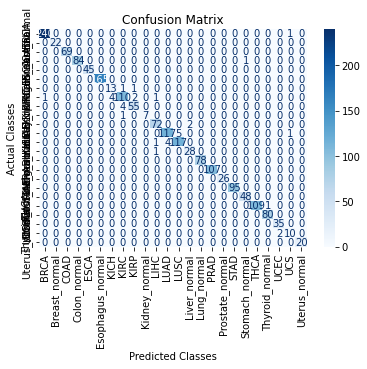

In [34]:
cm.plot(plot_lib = "seaborn",number_label=True, cmap=plt.cm.Blues)

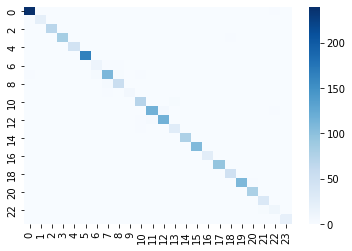

In [46]:
cm2 = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm2, fmt='', cmap='Blues')

In [49]:
Y = tcga_data_df.iloc[:,18212:18213].values

X_s = X
Y_s = Y


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

for j in range(10):
    i = 0
    for train, test in kfold.split(X_s, Y_s):

      X_s = X_s.reshape(X_s.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)

      label_encoder = LabelEncoder()
      integer_encoded = label_encoder.fit_transform(Y_s)
        # binary encode
      onehot_encoder = OneHotEncoder(sparse=False)
      integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
      onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
      num_classes = len(onehot_encoded[0])

      if i==0:
            model.summary()
            i = i +1
      history = model.fit(X_s[train], onehot_encoded[train],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0, callbacks=callbacks, validation_data=(X_s[test], onehot_encoded[test]))
      scores = model.evaluate(X_s[test], onehot_encoded[test], verbose=0)
        # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
      cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 66, 32)        1152      
_________________________________________________________________
activation (Activation)      (None, 35, 66, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2433152   
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 2,437,400
Trainable params: 2,437,400
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

99.98% (+/- 0.15%)
